# Integration of pciseq resuts into a h5ad (anndata) object

This script shows how to transform an ISS segmented dataset into an anndata object. The analysis is based on Scanpy (documentation in  https://scanpy.readthedocs.io/en/stable/index.html)

## Loading the packages

We import the packages needed for it. If something fails, means that we haven't installed something in the environment

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Load the functions

We load customized functions as well used to map the cell types in space

In [2]:
def map_of_clusters(adata,key='leiden',clusters='all',size=8,background='white',figuresize=(10,7),save=None,format='pdf'):
    
    #PARAMETERS TO MODIFY:
    #-key: the terms in adata.obs that you want to plot
    #-clusters:'all' for plotting all clusters in a single plot, 'individual': for plots of individual genes, or ['3','5'] (your groups
    #          between square brackets to plot only some clusters
    #-size: to change the size of your spots
    #-background: to change the color of the background
    #-figuresize: to specify the size of your figure
    #-save: if you want to save your figure, give the PATH of the folder where you want to save it
    #-format: specify the format in which you want to save your figure
    
    try:
        adata.obs[key]=adata.obs[key].astype(int)
        colors=dict(zip(np.unique(adata.obs[key]),adata.uns[key+'_colors']))
    except:
        colors=dict(zip(np.unique(adata.obs[key]),adata.uns[key+'_colors']))
    #cl.apply(lambda x: colors[x])
    plt.rcParams['figure.facecolor'] = background
    if clusters=='all':
        cl=adata.obs[key]
        plt.figure(figsize=figuresize)
        figa=plt.scatter(x=adata.obs.X,y=adata.obs.Y,c=cl.apply(lambda x: colors[x]),s=size,linewidths=0, edgecolors=None)
        plt.axis('off')
        if not save==None:
            plt.savefig(save +'/map_all_clusters_'+str(size)+'_'+background+'_'+key+'.'+format)
    elif clusters=='individual':
        cl=adata.obs[key]
        for each in adata.obs[key].unique():
            adatasub=adata[adata.obs[key]==each]
            plt.figure(figsize=figuresize)
            plt.scatter(x=adata.obs.X,y=adata.obs.Y,c='grey',s=size/5,linewidths=0, edgecolors=None)
            cl=adatasub.obs[key]
            plt.scatter(x=adatasub.obs.X,y=adatasub.obs.Y,c=cl.apply(lambda x: colors[x]),s=size,linewidths=0, edgecolors=None)
            plt.axis('off')
            plt.title('Group: '+ str(each))
            if not save==None:
                plt.savefig(save +'/map_inidivdual_cluster_'+str(each)+'_'+str(size)+background+'_'+key+'.'+format)
    else:
        adatasub=adata[adata.obs[key].isin(clusters)]
        plt.figure(figsize=figuresize)
        plt.scatter(x=adata.obs.X,y=adata.obs.Y,c='grey',s=size/5,linewidths=0, edgecolors=None)
        cl=adatasub.obs[key]
        plt.scatter(x=adatasub.obs.X,y=adatasub.obs.Y,c=cl.apply(lambda x: colors[x]),s=size,linewidths=0, edgecolors=None)
        plt.axis('off')
        plt.legend()
        if not save==None:
                s=''
                for element in clusters:
                    s=s+str(element)
                print(s)
                plt.savefig(save +'/map_group_of_clusters_'+str(s)+'_'+str(size)+background+'_'+key+'.'+format)
#        plt.title('Group: '+ paste(clusters))

## Importing the data and creating an anndata object

At this point of the pipeline we have both (1) segmentated datasets with an assigned IF value for every cell and (2) the assigned identity of every malignant cell (done via pciseq). We load both csv as dataframes

In [3]:
sample='A21-238_T_5'
path='F:/SAMPLES_DECODED/RUN2/'+sample

In [4]:
re=pd.read_csv(path+'/'+sample+'_CELLS_reads_ISS_and_IF.csv')
pciseq=pd.read_csv(path+'/'+sample+'_pciseq_results.csv')
pciseq=pciseq.iloc[:,-9:-1]

In [8]:
re.shape

(47258, 131)

We merge both datasets by matching the XY positions of every cell

In [9]:
data=re.merge(pciseq,on=['X','Y'],how='outer')

At this point our 'data' object contains both columns related with the expression of every cell and other metadata cell. We split those in two different datasets. `expdata` contains the columns related with expression, creating a cellxgene matrix. On the other side `metadata` contains the columns related with all metadata terms, including XY position and cell identity for the malignant

In [12]:
metadata=data.iloc[:,117:145]
expdata=data.iloc[:,range(0,117)]

We import our data in the scanpy object called "adata". This contains the expression of all cells and the metadata. 

In [13]:
adata = sc.AnnData(expdata)
adata.obs=metadata

C:\Users\sergio.salas\Miniconda3\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


The object where our data is contained is called anndata (documentation in https://anndata.readthedocs.io/en/latest/). The expression is stored in adata.X. The metadata is stored in adata.obs. The data associated with the genes is stored in adata.var

In [14]:
adata

AnnData object with n_obs × n_vars = 47258 × 117
    obs: 'GABRG2', 'CCDC153', 'MYL9', 'GPC3', 'TMEM212', 'BCAS1', 'PdHIST1H3B Mut_B2DO', 'X', 'Y', 'Cell_ID', 'Y_IF', 'X_IF', 'mean_IF', 'IF_Cell_ID', 'name', 'AC_like', 'Cycling', 'MES_like', 'OC_like', 'OPC_like'

 We calculate the total number of reads in each cell and store it in 'total_counts'.We keep cells with more than `minimum_numbers_of_reads` reads and less than `maximum_numbers_of_reads`

In [15]:
maximum_numbers_of_reads=50
minimum_number_of_reads=5

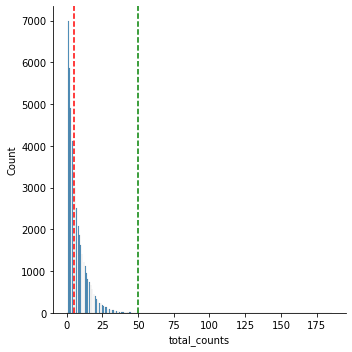

In [16]:
adata.obs['total_counts']=list(np.sum(expdata.loc[:,:],axis=1))
sns.displot(adata.obs,x='total_counts')
plt.axvline(x=maximum_numbers_of_reads,color='green',linestyle='--')
plt.axvline(x=minimum_number_of_reads,color='red',linestyle='--')
adata=adata[adata.obs['total_counts']>minimum_number_of_reads] #adjust the numbers to keep good cells according to appropiate ones
adata=adata[adata.obs['total_counts']<maximum_numbers_of_reads] #adjust the numbers to more than

We also filter the cells that do not contain at least expression of 3 different genes

In [17]:
sc.pp.filter_cells(adata,min_genes=3)

Trying to set attribute `.obs` of view, copying.
C:\Users\sergio.salas\Miniconda3\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# Normalization of the data

We now save the raw data in adata.raw and apply normalization and log-transformation to minimize the effect of outliers. We also scale the data to give the same importance to all genes in clustering

In [18]:
adata.raw=adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

[OPTIONAL] After normalizing and logmarizing, the data we CAN, if we wish, filter only highly variable genes for clustering. This step is key in the analysis of single cell RNA sequencing datasets (with +20.000 genes) but it's not that useful in targeted methods such as ISS. However, it can help to keep variables only for clustering

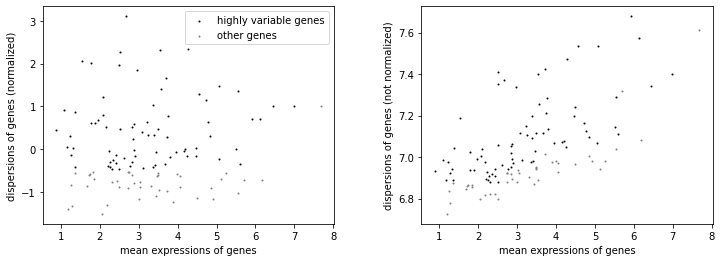

In [19]:
plt.rcParams['figure.facecolor'] = 'white'
sc.pp.highly_variable_genes(adata, min_mean=0.3, max_mean=7, min_disp=-0.5)
sc.pl.highly_variable_genes(adata)
adata=adata[:,adata.var.highly_variable==True]

We can plot the IF values for every type of malignant cell detected

C:\Users\sergio.salas\Miniconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\sergio.salas\Miniconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\sergio.salas\Miniconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\sergio.salas\Miniconda3\lib\site-packages\seaborn\distributions.py:1699: Future

<AxesSubplot:xlabel='mean_IF', ylabel='Density'>

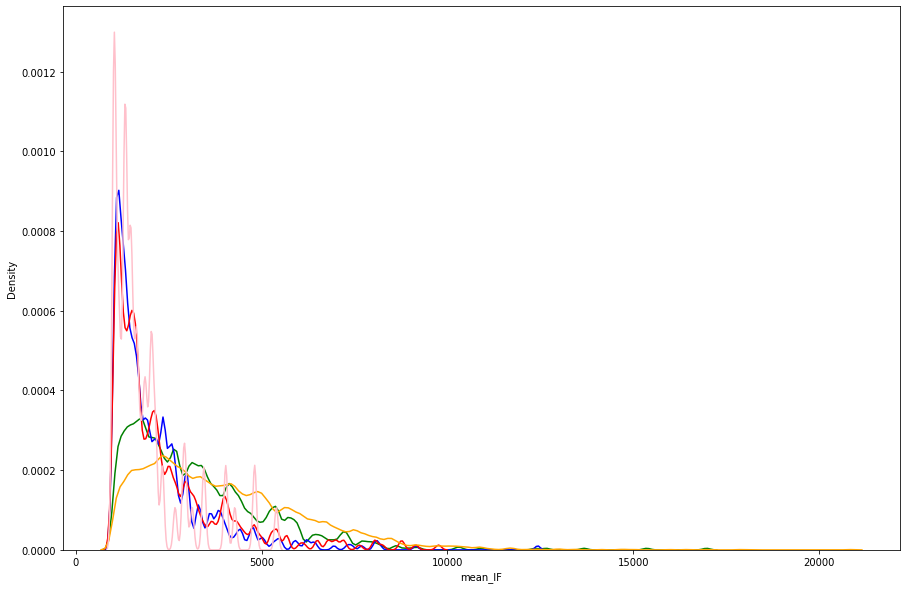

In [30]:
ames=adata[adata.obs['name']=='MES_like']
aoc=adata[adata.obs['name']=='OC_like']
aopc=adata[adata.obs['name']=='OPC_like']
aac=adata[adata.obs['name']=='AC_like']
acycling=adata[adata.obs['name']=='Cycling']

plt.figure(figsize=(15,10))
sns.kdeplot(ames.obs['mean_IF'], bw=0.05,color='green')
sns.kdeplot(aoc.obs['mean_IF'], bw=0.05,color='blue')
sns.kdeplot(aopc.obs['mean_IF'], bw=0.05,color='red')
sns.kdeplot(aac.obs['mean_IF'], bw=0.05,color='orange')
sns.kdeplot(acycling.obs['mean_IF'], bw=0.05,color='pink')

# Plotting clusters on the tissue

We now go back to the tissue and plot the cell types back. For this we use the function 'map_of_clusters' to plot clusters on the tissue

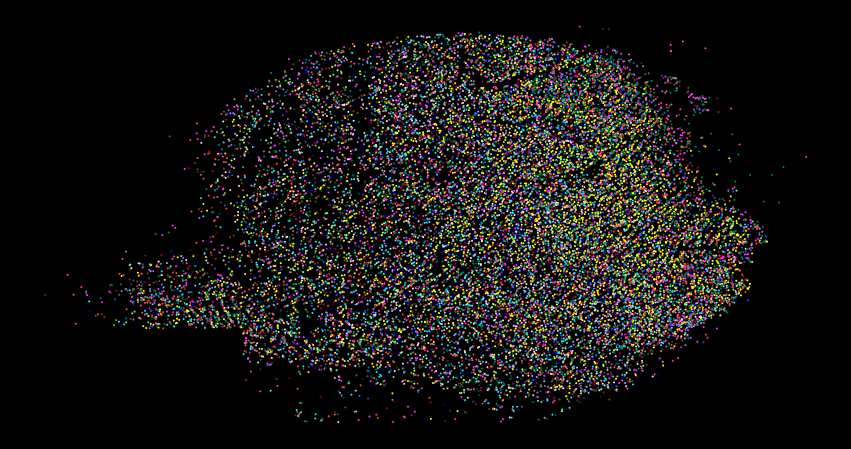

In [33]:
map_of_clusters(adata,key='leiden',size=4,background='black',clusters='all',figuresize=(15,8))

In dotplots, the stronger the color is (according to the legend), the higher the mean expression is. In addition, the size of the circle represents the percentage of cells in the clusters that are expressing a certain gene

# Saving and loading an anndata object

Depending on your data, it might take a while to go though all this analysis successfully. Therefore, it's interesting that you can save and load your processed data whenever you want. We will use this h5 adata object from every sample to integrate all samples together in a common analysis. To save your object, you use the following command:


In [35]:
path+'/'+'adata'+sample+'.h5'

'F:/SAMPLES_DECODED/RUN2/A21-238_T_5/adataA21-238_T_5.h5'

In [34]:
adata.write(path+'/'+'adata'+sample+'.h5')

On the other hand, if you wish to load the pre-saved object,just do:

In [190]:
adata=sc.read(path+'/'+'adata'+sample+'.h5')